In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# EDA
train = pd.read_csv("/kaggle/input/titanic/train.csv")
#train.head
train.info
# train.shape
# train.isnull().sum()
# train['Embarked'].value_counts()
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [11]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

549 passengers died, and 342 passengers survived. Of those survivng passengers, what characteristics did they have that may have contributed to their survival? 

In [12]:
train['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

64% of the passengers are male, and 35% of the passengers are female. Because there are more male passengers, it can be mistakenly inferred that being male came with a higher chance of surviving/not surviving. We wouldn't necessarily know if the same could be said for female passengers, as there aren't an equal amount of them and their results to compare to males, and vice-versa.

In [13]:
my_agg=(train
 .groupby(['Sex','Survived'])
 .agg(
     fates=pd.NamedAgg('Survived', 'count')))
print(my_agg)

                 fates
Sex    Survived       
female 0            81
       1           233
male   0           468
       1           109


More females survived than died in their group, and more males died than survived in their group. What other factors might have played into this?

In [14]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

It looks as if most of the passengers (75% of them) are age 38 and below.

In [15]:
mybins = pd.IntervalIndex.from_tuples([(0,10),(10,20),(20,30),(30,40),(40,50),(50,60),(60,70),(70,80)])
train.groupby(['Sex', 
               'Survived', 
               pd.cut(x=train['Age'],
                      bins=mybins)
              ])\
      .size()\
      .unstack()

Age              (0, 10]  (10, 20]  (20, 30]  (30, 40]  (40, 50]  (50, 60]  \
Sex    Survived                                                              
female 0              12        12        20         9        10         1   
       1              19        34        61        46        21        13   
male   0              14        59       126        77        43        24   
       1              19        10        23        23        12         4   

Age              (60, 70]  (70, 80]  
Sex    Survived                      
female 0                0         0  
       1                3         0  
male   0               13         4  
       1                1         1

Because there isn't an even number of each age to properly determine whether age played a huge factor into surviving or not, I placed their ages into buckets:

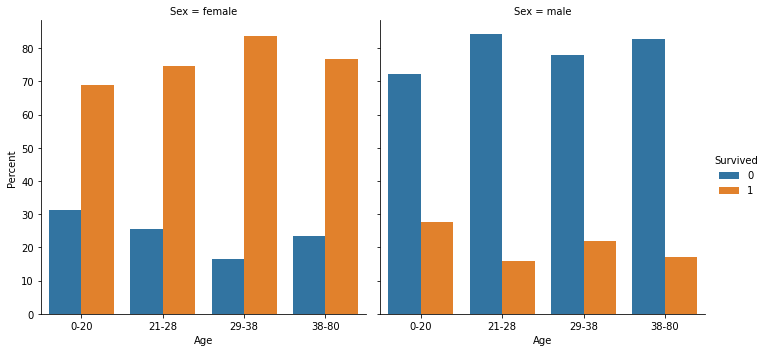

In [16]:
train.groupby(['Sex',
              pd.cut(x=train['Age'],
                      bins=train['Age'].quantile([0,.25,.5,.75,1]),
                      labels=['0-20','21-28','29-38','38-80'])
              ],\
             )['Survived']\
    .value_counts(normalize=True)\
    .mul(100)\
    .rename('Percent')\
    .reset_index(level=1)\
    .reset_index(level=1)\
    .reset_index(level=0)\
    .pipe((sns.catplot,'data'), x='Age', y='Percent', hue='Survived', col='Sex', kind='bar')

Bucketing the ages is more meaningful than not bucketing them. There's more clarity in seeing the results with bucketed ages versus individual, several ages on the x-axis. There's still a clear indication that survivng (or not) increased or decreased with age.

([<matplotlib.patches.Wedge at 0x7fbb5b39b2d0>,
 [Text(-1.6288120254956846, -0.2635742506403942, '3rd class'),
  Text(1.4571365927931532, -0.7741143003091732, '1st class'),
  Text(0.9969395548015787, 1.3147667184987724, '2nd class')],
 [Text(-0.888442922997646, -0.14376777307657862, '55%'),
  Text(0.7948017778871743, -0.42224416380500346, '24%'),
  Text(0.5437852117099519, 0.7171454828175121, '21%')])

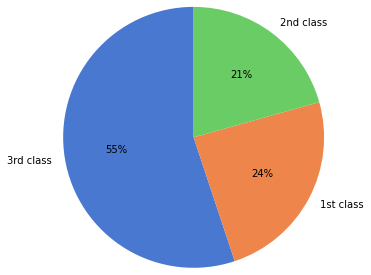

In [32]:
train.Pclass.value_counts()\
     .pipe((plt.pie, 'x'),
           labels=['3rd class', '1st class', '2nd class'], 
           colors=sns.color_palette('muted'), 
           autopct='%.0f%%',
           startangle=90, 
           radius=1.5)

More than half the passengers' socio-economic statuses were considered 3rd class. Many of them had the goal of creating a new life in America – the final destination of the RMS Titanic.

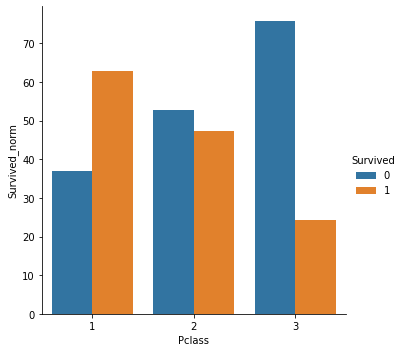

In [18]:
train.groupby(['Pclass'])['Survived']\
    .value_counts(normalize=True)\
    .mul(100)\
    .to_frame()\
    .rename(columns={'Survived': 'Survived_norm'})\
    .sort_values(by=['Pclass', 'Survived'])\
    .reset_index()\
    .pipe((sns.catplot, 'data'), x='Pclass', y='Survived_norm', hue='Survived', kind='bar')

Even after transforming the total number of passengers in each SES to a common scale, it's not surprising that it's still the case that 3rd class passengers survived the least out of the other classes, and that survival was less common the lower SES a passenger was. 

3rd class passengers included a wide range of nationalities, according to [this website](http://www.icyousee.org/titanic.html#nation). As mentioned earlier, many 3rd class passengers were immigrants hoping to make a new life in America. Like many of them on the Titanic, I was also an immigrant to America. I didn't understand English well. As the crew spoke mostly English, it's very possible that language barrier could've had a play in preventing 3rd class passengers from escaping safely. Titanic's lifeboats were also located at its very highest deck, which 1st class passengers were closest to. As a result, being a 3rd class immigrant passenger that did not understand English aboard the Titanic likely meant both a scary and extremely confusing ordeal.

In [22]:
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Using the 'Cabin' column, I'll get to see if cabin location really did have an impact on whether a person survived or not. Another thing to consider is whether passengers were in or near their cabins when the Titanic started sinking. According to [this website](https://americanhistory.si.edu/collections/search/object/nmah_1416178), the Titanic hit the iceberg at 11:40 PM, and completely sank at 2:20 AM. Using that information, I'm going to conclude that passengers were in their cabins sleeping, or getting ready to sleep.

In [54]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Unfortunately, 77% of the 'Cabin' column is null, so it may not be the best feature to select when creating the model.

I want to see if there were any 3rd class passengers that had a large fare to see if their chance of survival was higher. Similarly, I also want to see if there were any 1st class passengers that had a small fare, and did not survive. I'm doing this to determine whether it might be more accurate to use fare as an indicator for survival rather than socio-economic status.

In [80]:
train[['Pclass', 'Fare', 'Survived']]\
    .query('Pclass==3')\
    .value_counts()\
    .reset_index()\
    .sort_values(by='Fare', ascending=False)\
    .rename(columns={0: "Survived_count"})\
#     .pipe((sns.catplot, 'data'), x='Fare', y='Survived_count', hue='Survived', kind='bar')

,Pclass,Fare,Survived,Survived_count
12,3,69.5500,0,7
25,3,56.4958,1,5
72,3,56.4958,0,2
21,3,46.9000,0,6
20,3,39.6875,0,6
...,...,...,...,...
83,3,6.4375,0,1
85,3,6.2375,0,1
86,3,4.0125,0,1
43,3,0.0000,0,3
